In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import os

In [8]:
# ===============================================================
# 🏆 INDIVIDUAL AWARDS PREDICTION — DATA PREPARATION
# ===============================================================

# ===============================================================
# 1️⃣ Load Data
# ===============================================================
players = pd.read_csv("data/players.csv")
players_teams = pd.read_csv("data/players_teams.csv")
awards = pd.read_csv("data/awards_players.csv")
teams = pd.read_csv("data/teams.csv")

# ===============================================================
# 2️⃣ Filter to main awards only
# ===============================================================
main_awards = [
    'Most Valuable Player',
    'Defensive Player of the Year',
    'Rookie of the Year'
]
awards_main = awards[awards['award'].isin(main_awards)]

print(f"Total awards: {len(awards_main)}")
print(awards_main['award'].value_counts())

# ===============================================================
# 3️⃣ Create player performance features
# ===============================================================
player_stats = players_teams.copy()

# Filter players with significant playing time (>= 10 games)
player_stats = player_stats[player_stats['GP'] >= 10]

# Per-game statistics
player_stats['ppg'] = player_stats['points'] / player_stats['GP']
player_stats['rpg'] = player_stats['rebounds'] / player_stats['GP']
player_stats['apg'] = player_stats['assists'] / player_stats['GP']
player_stats['spg'] = player_stats['steals'] / player_stats['GP']
player_stats['bpg'] = player_stats['blocks'] / player_stats['GP']
player_stats['mpg'] = player_stats['minutes'] / player_stats['GP']

# Shooting efficiency
player_stats['fg_pct'] = np.where(
    player_stats['fgAttempted'] > 0,
    player_stats['fgMade'] / player_stats['fgAttempted'],
    0
)

# Simple efficiency rating
player_stats['efficiency'] = (
    player_stats['points'] + player_stats['rebounds'] + 
    player_stats['assists'] + player_stats['steals'] + 
    player_stats['blocks'] - player_stats['turnovers']
) / player_stats['GP']

# Games started percentage
player_stats['gs_pct'] = player_stats['GS'] / player_stats['GP']

# ===============================================================
# 4️⃣ Add team success metrics
# ===============================================================
teams_success = teams[['year', 'tmID', 'won', 'lost']].copy()
teams_success['win_pct'] = teams_success['won'] / (teams_success['won'] + teams_success['lost'])

player_stats = player_stats.merge(teams_success, on=['year', 'tmID'], how='left')

# ===============================================================
# 5️⃣ Identify rookies (first year players)
# ===============================================================
player_stats = player_stats.sort_values(['playerID', 'year'])
player_stats['is_rookie'] = player_stats.groupby('playerID').cumcount() == 0
player_stats['is_rookie'] = player_stats['is_rookie'].astype(int)

# ===============================================================
# 6️⃣ Create target variables for each award
# ===============================================================
for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    player_stats[col_name] = 0
    
    for _, row in awards_main[awards_main['award'] == award].iterrows():
        mask = (player_stats['playerID'] == row['playerID']) & \
               (player_stats['year'] == row['year'])
        player_stats.loc[mask, col_name] = 1

# ===============================================================
# 7️⃣ Fill missing values
# ===============================================================
player_stats['win_pct'] = player_stats['win_pct'].fillna(0.5)

# ===============================================================
# 8️⃣ Save prepared dataset
# ===============================================================
os.makedirs("data_models", exist_ok=True)
player_stats.to_csv("data_models/awards_dataset.csv", index=False)

print("\n✅ Dataset ready: data_models/awards_dataset.csv")
print(f"Shape: {player_stats.shape}")
print("\nAward winners distribution:")
for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    winners = player_stats[col_name].sum()
    print(f"{award}: {winners} winners")

Total awards: 30
award
Defensive Player of the Year    10
Most Valuable Player            10
Rookie of the Year              10
Name: count, dtype: int64

✅ Dataset ready: data_models/awards_dataset.csv
Shape: (1603, 59)

Award winners distribution:
Most Valuable Player: 10 winners
Defensive Player of the Year: 10 winners
Rookie of the Year: 10 winners


Treino: (1458, 59) | Teste (10): (145, 59)

MVP winners in training: 9
MVP winners in test: 1
Class balance: 9/1458 = 0.62%

📊 MVP Ranking Evaluation for year 10:
Actual winner rank: 1 out of 145
Actual winner probability: 0.405
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT

🏆 Top 10 MVP candidates:
        playerID tmID        ppg       rpg       apg  mvp_proba  mvp_rank  \
1362  tauradi01w  PHO  20.354839  5.741935  3.516129   0.404845       1.0   
1099  pondeca01w  PHO  19.058824  4.235294  5.029412   0.075000       2.0   
630   jacksla01w  SEA  19.192308  7.000000  0.846154   0.034998       3.0   
1054  parkeca01w  LAS  13.120000  9.760000  2.560000   0.025000       4.0   
515   hammobe01w  SAS  19.483871  3.322581  5.032258   0.020000       5.0   
1596  youngso01w  SAS  18.181818  6.515152  1.636364   0.010000       6.0   
319   desouer01w  ATL  11.823529  9.088235  1.117647   0.005000       7.0   
346   douglka01w  IND  17.645161  3.870968  2

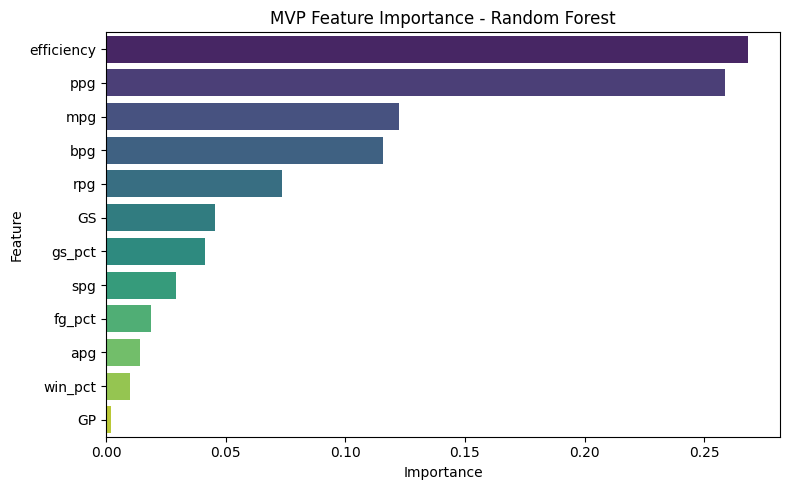


💡 Top 5 Most Important Features:
      Feature  Importance
7  efficiency    0.268311
0         ppg    0.258636
5         mpg    0.122356
4         bpg    0.115873
1         rpg    0.073610

✅ Results saved to: data_models/predictions_mvp.csv


In [19]:
# ===============================================================
# 🏀 MVP PREDICTION — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# 1️⃣ Load prepared dataset
# ===============================================================
player_df = pd.read_csv("data_models/awards_dataset.csv")

# ===============================================================
# 2️⃣ Choose target year
# ===============================================================
target_year = 10
train_data = player_df[player_df["year"] < target_year]
test_data = player_df[player_df["year"] == target_year]

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")

# ===============================================================
# 3️⃣ Define features and target for MVP
# ===============================================================
features = [
    'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg',
    'fg_pct', 'efficiency', 'gs_pct', 'win_pct', 'GP', 'GS'
]
target = 'won_most_valuable_player'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

print(f"\nMVP winners in training: {y_train.sum()}")
print(f"MVP winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# 4️⃣ Train Random Forest model
# ===============================================================
model_mvp = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model_mvp.fit(X_train, y_train)

# ===============================================================
# 5️⃣ Predictions
# ===============================================================
test_data = test_data.copy()
test_data.loc[:, 'mvp_proba'] = model_mvp.predict_proba(X_test)[:, 1]

# Rank players by probability
test_data.loc[:, 'mvp_rank'] = test_data['mvp_proba'].rank(ascending=False, method='first')

# ===============================================================
# 6️⃣ Evaluation
# ===============================================================
# For awards, what matters is: Is the winner in our top predictions?
actual_winner_id = test_data[test_data[target] == 1]['playerID'].values
if len(actual_winner_id) > 0:
    actual_winner_id = actual_winner_id[0]
    winner_rank = test_data[test_data['playerID'] == actual_winner_id]['mvp_rank'].values[0]
    winner_proba = test_data[test_data['playerID'] == actual_winner_id]['mvp_proba'].values[0]
    
    print(f"\n📊 MVP Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_data)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
else:
    print("\nNo MVP winner in test set")

# ===============================================================
# 7️⃣ Top MVP candidates
# ===============================================================
print("\n🏆 Top 10 MVP candidates:")
top_mvp = test_data[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'win_pct', 'mvp_proba', 'mvp_rank', 'won_most_valuable_player'
]].sort_values('mvp_proba', ascending=False).head(10)
print(top_mvp[['playerID', 'tmID', 'ppg', 'rpg', 'apg', 'mvp_proba', 'mvp_rank', 'won_most_valuable_player']])

# ===============================================================
# 8️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model_mvp.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('MVP Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

print("\n💡 Top 5 Most Important Features:")
print(importance.head())

# ===============================================================
# 9️⃣ Save predictions
# ===============================================================
test_data.to_csv("data_models/predictions_mvp.csv", index=False)
print("\n✅ Results saved to: data_models/predictions_mvp.csv")

DPOY winners in training: 9
DPOY winners in test: 1
Class balance: 9/1458 = 0.62%

📊 DPOY Ranking Evaluation for year 10:
Actual winner rank: 1 out of 145
Actual winner probability: 0.255
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT

🛡️ Top 10 DPOY candidates:
        playerID tmID       spg       bpg       rpg  dpoy_proba  dpoy_rank  \
241   catchta01w  IND  2.911765  0.529412  7.205882    0.254840        1.0   
26    anosini01w  MIN  2.700000  0.933333  7.400000    0.110000        2.0   
1362  tauradi01w  PHO  1.161290  1.387097  5.741935    0.064732        3.0   
575   hoffmeb01w  IND  1.676471  0.352941  5.852941    0.039903        4.0   
351   dupreca01w  CHI  1.029412  1.205882  7.882353    0.029748        5.0   
1054  parkeca01w  LAS  0.600000  2.120000  9.760000    0.025000        6.0   
630   jacksla01w  SEA  1.461538  1.730769  7.000000    0.024980        7.0   
346   douglka01w  IND  1.806452  0.225806  3.870968    0.014928        8.0  

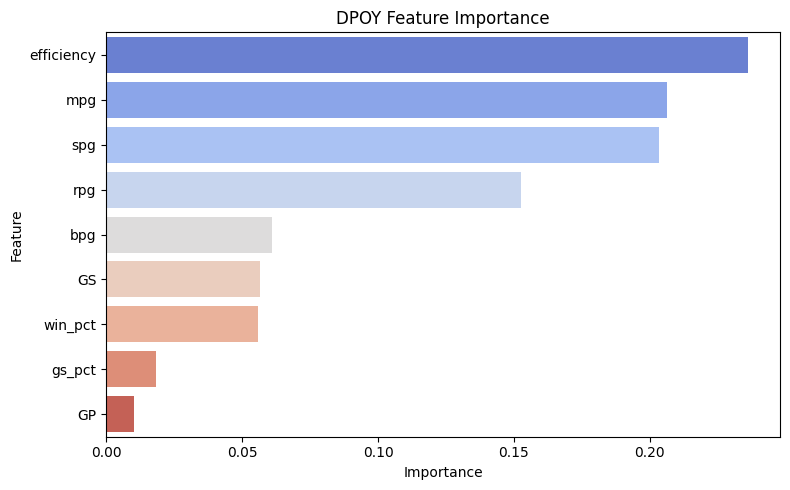


💡 Top 5 Most Important Features:
      Feature  Importance
4  efficiency    0.236079
3         mpg    0.206206
0         spg    0.203333
2         rpg    0.152453
1         bpg    0.061081

✅ Results saved to: data_models/predictions_dpoy.csv


In [20]:
# ===============================================================
# 🛡️ DEFENSIVE PLAYER OF THE YEAR — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# 1️⃣ Load data (already prepared)
# ===============================================================
target_year = 10
train_data = player_df[player_df["year"] < target_year]
test_data = player_df[player_df["year"] == target_year]

# ===============================================================
# 2️⃣ Features focused on defense
# ===============================================================
features_dpoy = [
    'spg', 'bpg', 'rpg', 'mpg', 'efficiency',
    'gs_pct', 'win_pct', 'GP', 'GS'
]
target = 'won_defensive_player_of_the_year'

X_train = train_data[features_dpoy]
y_train = train_data[target]
X_test = test_data[features_dpoy]
y_test = test_data[target]

print(f"DPOY winners in training: {y_train.sum()}")
print(f"DPOY winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# 3️⃣ Train model
# ===============================================================
model_dpoy = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model_dpoy.fit(X_train, y_train)

# ===============================================================
# 4️⃣ Predictions
# ===============================================================
test_data = test_data.copy()
test_data.loc[:, 'dpoy_proba'] = model_dpoy.predict_proba(X_test)[:, 1]
test_data.loc[:, 'dpoy_rank'] = test_data['dpoy_proba'].rank(ascending=False, method='first')

# ===============================================================
# 5️⃣ Evaluation
# ===============================================================
actual_winner_id = test_data[test_data[target] == 1]['playerID'].values
if len(actual_winner_id) > 0:
    actual_winner_id = actual_winner_id[0]
    winner_rank = test_data[test_data['playerID'] == actual_winner_id]['dpoy_rank'].values[0]
    winner_proba = test_data[test_data['playerID'] == actual_winner_id]['dpoy_proba'].values[0]
    
    print(f"\n📊 DPOY Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_data)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
else:
    print("\nNo DPOY winner in test set")

# ===============================================================
# 6️⃣ Top DPOY candidates
# ===============================================================
print("\n🛡️ Top 10 DPOY candidates:")
top_dpoy = test_data[[
    'playerID', 'tmID', 'spg', 'bpg', 'rpg',
    'dpoy_proba', 'dpoy_rank', 'won_defensive_player_of_the_year'
]].sort_values('dpoy_proba', ascending=False).head(10)
print(top_dpoy[['playerID', 'tmID', 'spg', 'bpg', 'rpg', 'dpoy_proba', 'dpoy_rank', 'won_defensive_player_of_the_year']])

# ===============================================================
# 7️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_dpoy,
    'Importance': model_dpoy.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='coolwarm', legend=False)
plt.title('DPOY Feature Importance')
plt.tight_layout()
plt.show()

print("\n💡 Top 5 Most Important Features:")
print(importance.head())

# ===============================================================
# 8️⃣ Save predictions
# ===============================================================
test_data.to_csv("data_models/predictions_dpoy.csv", index=False)
print("\n✅ Results saved to: data_models/predictions_dpoy.csv")

Rookie training data: (441, 59)
Rookie test data: (20, 59)

ROY winners in training: 9
ROY winners in test: 1
Class balance: 9/441 = 2.04%

📊 ROY Ranking Evaluation for year 10:
Actual winner rank: 2 out of 20
Actual winner probability: 0.005
Top-1 prediction: ✗ INCORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT

🌟 Top 10 Rookie of the Year candidates:
       playerID tmID        ppg       rpg       apg  roy_proba  roy_rank  \
130  bonnede01w  PHO  11.205882  5.764706  0.382353      0.010       1.0   
883  mccouan01w  ATL  12.794118  3.088235  2.088235      0.005       2.0   
264  colemma01w  WAS   6.107143  2.714286  0.785714      0.000       4.0   
106  blackch01w  CON   2.939394  3.242424  0.181818      0.000       3.0   
436  frazeme01w  SAS   5.000000  2.896552  0.517241      0.000       5.0   
590  holliqu01w  MIN   4.823529  3.235294  0.147059      0.000       6.0   
648  jekaban01w  CON   9.444444  2.888889  2.185185      0.000       8.0   
647  januabr01w  IND  

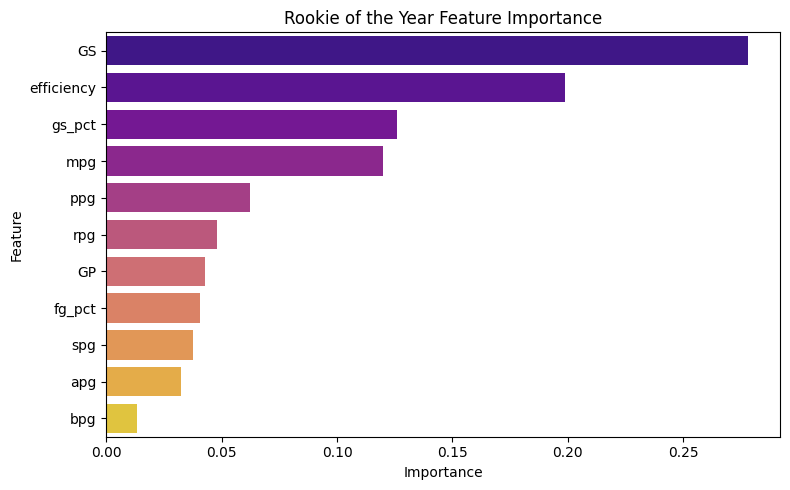


💡 Top 5 Most Important Features:
       Feature  Importance
10          GS    0.278027
7   efficiency    0.198937
8       gs_pct    0.125867
5          mpg    0.119742
0          ppg    0.062428

✅ Results saved to: data_models/predictions_roy.csv


In [21]:
# ===============================================================
# 🌟 ROOKIE OF THE YEAR — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# 1️⃣ Filter only rookies
# ===============================================================
target_year = 10
train_rookies = player_df[(player_df["year"] < target_year) & (player_df["is_rookie"] == 1)]
test_rookies = player_df[(player_df["year"] == target_year) & (player_df["is_rookie"] == 1)]

print(f"Rookie training data: {train_rookies.shape}")
print(f"Rookie test data: {test_rookies.shape}")

# ===============================================================
# 2️⃣ Features for rookies
# ===============================================================
features_roy = [
    'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg',
    'fg_pct', 'efficiency', 'gs_pct', 'GP', 'GS'
]
target = 'won_rookie_of_the_year'

X_train = train_rookies[features_roy]
y_train = train_rookies[target]
X_test = test_rookies[features_roy]
y_test = test_rookies[target]

print(f"\nROY winners in training: {y_train.sum()}")
print(f"ROY winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# 3️⃣ Train model
# ===============================================================
model_roy = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)
model_roy.fit(X_train, y_train)

# ===============================================================
# 4️⃣ Predictions
# ===============================================================
test_rookies = test_rookies.copy()
test_rookies.loc[:, 'roy_proba'] = model_roy.predict_proba(X_test)[:, 1]
test_rookies.loc[:, 'roy_rank'] = test_rookies['roy_proba'].rank(ascending=False, method='first')

# ===============================================================
# 5️⃣ Evaluation
# ===============================================================
actual_winner_id = test_rookies[test_rookies[target] == 1]['playerID'].values
if len(actual_winner_id) > 0:
    actual_winner_id = actual_winner_id[0]
    winner_rank = test_rookies[test_rookies['playerID'] == actual_winner_id]['roy_rank'].values[0]
    winner_proba = test_rookies[test_rookies['playerID'] == actual_winner_id]['roy_proba'].values[0]
    
    print(f"\n📊 ROY Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_rookies)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
else:
    print("\nNo ROY winner in test set")

# ===============================================================
# 6️⃣ Top ROY candidates
# ===============================================================
print("\n🌟 Top 10 Rookie of the Year candidates:")
top_roy = test_rookies[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'roy_proba', 'roy_rank', 'won_rookie_of_the_year'
]].sort_values('roy_proba', ascending=False).head(10)
print(top_roy[['playerID', 'tmID', 'ppg', 'rpg', 'apg', 'roy_proba', 'roy_rank', 'won_rookie_of_the_year']])

# ===============================================================
# 7️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_roy,
    'Importance': model_roy.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='plasma', legend=False)
plt.title('Rookie of the Year Feature Importance')
plt.tight_layout()
plt.show()

print("\n💡 Top 5 Most Important Features:")
print(importance.head())

# ===============================================================
# 8️⃣ Save predictions
# ===============================================================
test_rookies.to_csv("data_models/predictions_roy.csv", index=False)
print("\n✅ Results saved to: data_models/predictions_roy.csv")

In [ ]:
# ===============================================================
# 📋 SUMMARY OF ALL AWARD PREDICTIONS
# ===============================================================

print("="*70)
print(f"FINAL AWARD PREDICTIONS FOR YEAR {target_year}")
print("="*70)

mvp_pred = pd.read_csv("data_models/predictions_mvp.csv")
dpoy_pred = pd.read_csv("data_models/predictions_dpoy.csv")
roy_pred = pd.read_csv("data_models/predictions_roy.csv")

mvp_winner = mvp_pred.nlargest(1, 'mvp_proba')
dpoy_winner = dpoy_pred.nlargest(1, 'dpoy_proba')
roy_winner = roy_pred.nlargest(1, 'roy_proba')

mvp_actual = mvp_pred[mvp_pred['won_most_valuable_player'] == 1]
dpoy_actual = dpoy_pred[dpoy_pred['won_defensive_player_of_the_year'] == 1]
roy_actual = roy_pred[roy_pred['won_rookie_of_the_year'] == 1]

print("\n🏆 MOST VALUABLE PLAYER:")
print(f"  Predicted: {mvp_winner['playerID'].values[0]}")
print(f"  Team: {mvp_winner['tmID'].values[0]}")
print(f"  PPG: {mvp_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {mvp_winner['rpg'].values[0]:.1f}")
print(f"  APG: {mvp_winner['apg'].values[0]:.1f}")
print(f"  Confidence: {mvp_winner['mvp_proba'].values[0]:.1%}")
if len(mvp_actual) > 0:
    is_correct = mvp_winner['playerID'].values[0] == mvp_actual['playerID'].values[0]
    actual_rank = int(mvp_actual['mvp_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {mvp_actual['playerID'].values[0]}")

print("\n🛡️ DEFENSIVE PLAYER OF THE YEAR:")
print(f"  Predicted: {dpoy_winner['playerID'].values[0]}")
print(f"  Team: {dpoy_winner['tmID'].values[0]}")
print(f"  SPG: {dpoy_winner['spg'].values[0]:.1f}")
print(f"  BPG: {dpoy_winner['bpg'].values[0]:.1f}")
print(f"  RPG: {dpoy_winner['rpg'].values[0]:.1f}")
print(f"  Confidence: {dpoy_winner['dpoy_proba'].values[0]:.1%}")
if len(dpoy_actual) > 0:
    is_correct = dpoy_winner['playerID'].values[0] == dpoy_actual['playerID'].values[0]
    actual_rank = int(dpoy_actual['dpoy_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {dpoy_actual['playerID'].values[0]}")

print("\n🌟 ROOKIE OF THE YEAR:")
print(f"  Predicted: {roy_winner['playerID'].values[0]}")
print(f"  Team: {roy_winner['tmID'].values[0]}")
print(f"  PPG: {roy_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {roy_winner['rpg'].values[0]:.1f}")
print(f"  APG: {roy_winner['apg'].values[0]:.1f}")
print(f"  Confidence: {roy_winner['roy_proba'].values[0]:.1%}")
if len(roy_actual) > 0:
    is_correct = roy_winner['playerID'].values[0] == roy_actual['playerID'].values[0]
    actual_rank = int(roy_actual['roy_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {roy_actual['playerID'].values[0]}")

correct = 0
total = 0
if len(mvp_actual) > 0:
    correct += (mvp_winner['playerID'].values[0] == mvp_actual['playerID'].values[0])
    total += 1
if len(dpoy_actual) > 0:
    correct += (dpoy_winner['playerID'].values[0] == dpoy_actual['playerID'].values[0])
    total += 1
if len(roy_actual) > 0:
    correct += (roy_winner['playerID'].values[0] == roy_actual['playerID'].values[0])
    total += 1

print("\n" + "="*70)
print(f"Overall Top-1 Accuracy: {correct}/{total} = {correct/total*100:.1f}%" if total > 0 else "No winners in test set")
print("="*70)
print("✅ All predictions complete!")


FINAL AWARD PREDICTIONS FOR YEAR 10

🏆 MOST VALUABLE PLAYER:
  Predicted: tauradi01w
  Team: PHO
  PPG: 20.4
  RPG: 5.7
  APG: 3.5
  Confidence: 40.5%
  Prediction: ✓ CORRECT
  Actual winner: tauradi01w

🛡️ DEFENSIVE PLAYER OF THE YEAR:
  Predicted: catchta01w
  Team: IND
  SPG: 2.9
  BPG: 0.5
  RPG: 7.2
  Confidence: 25.5%
  Prediction: ✓ CORRECT
  Actual winner: catchta01w

🌟 ROOKIE OF THE YEAR:
  Predicted: bonnede01w
  Team: PHO
  PPG: 11.2
  RPG: 5.8
  APG: 0.4
  Confidence: 1.0%
  Prediction: ✗ INCORRECT (actual winner ranked #2)
  Actual winner: mccouan01w

Overall Top-1 Accuracy: 2/3 = 66.7%
✅ All predictions complete!
